In [2]:
import glob
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

names = []
dfs = []

for file in glob.glob("/Users/dguittet/Projects/Dispatches/dispatches/dispatches/models/renewables_case/wind_battery_results_*.csv"):
    name = Path(file).stem.split("uncertainty_w_")[1]
    if 'eagle' in name:
        continue
    names.append(name)
    df = pd.read_csv(file)
    df.set_index("DateTime")
    dfs.append(df)

In [112]:
def plot_lmps_vs_time(max_charge_lmp, min_discharge_lmp, FECs):
    """
    Plots each Time Interval's Max Charge LMPs and Min Discharge LMPs over Time
    """
    max_charge_lmp = np.array(max_charge_lmp)
    min_discharge_lmp = np.array(min_discharge_lmp)

    fig, ax = plt.subplots(1, 1, figsize=(24, 3))
    ax.plot(max_charge_lmp[0:], label="Max Charge LMP")
    ax.plot(min_discharge_lmp[0:], label="Min Discharge LMP")
    ax.set_xlabel("Day")
    ax.set_ylabel("$/MWh")
    ax.legend()
    ax11 = ax.twinx()
    ax11.plot(FECs, 'y', label="FECs")
    ax11.legend(loc='lower right')
    plt.title("LMPs per Interval vs Time")


def plot_lmps_sorted(max_charge_lmp, min_discharge_lmp, ax):
    """
    Plots each Time Interval's Max Charge LMPs and Min Discharge LMPs Sorted by increasing order
    """
    max_charge_lmp_sorted = np.sort(max_charge_lmp)
    min_discharge_lmp_sorted = np.sort(min_discharge_lmp)

    ax.scatter(range(len(max_charge_lmp_sorted)), max_charge_lmp_sorted, label="Max Charge LMP", alpha=0.4)
    ax.scatter(range(len(min_discharge_lmp_sorted)), min_discharge_lmp_sorted, label="Min Discharge LMP", alpha=0.4)
    ax.set_xlabel("N")
    ax.set_ylabel("$/MWh")
    ax.legend()
    ax.set_title("LMPs per Interval in Increasing Order")


def plot_lmps_vs_FECs(max_charge_lmp, min_discharge_lmp, FECs, ax):
    """
    Plots each Time Interval's Max Charge LMPs and Min Discharge LMPs vs that Interval's number of Full Energy Cycles
    """
    bid_curve = list(zip(max_charge_lmp, FECs))
    bid_curve.sort()
    bid_curve = np.array(bid_curve)
    ax.scatter(bid_curve[:, 1], bid_curve[:, 0], label="Max Charge LMP", alpha=0.4)
    ax.set_xlabel("FECs")
    ax.set_xlim((0, None))

    bid_curve = list(zip(min_discharge_lmp, FECs))
    bid_curve.sort()
    bid_curve = np.array(bid_curve)
    ax.scatter(bid_curve[:, 1], bid_curve[:, 0], label="Min Discharge LMP", alpha=0.4)
    ax.set_ylim((-5, max(min_discharge_lmp) + 5))
    ax.legend()
    ax.set_title("LMPs per Interval vs Battery Full Energy Cycles")


def plot_lmps_vs_SOC(max_charge_lmp, min_discharge_lmp, charge_SOC, discharge_SOC, ax):
    """
    Plots each Time Interval's Max Charge LMPs and Min Discharge LMPs vs the average SOCs at start time of charges or discharges
    """
    bid_curve = list(zip(max_charge_lmp, charge_SOC))
    bid_curve.sort()
    bid_curve = np.array(bid_curve)
    ax.scatter(bid_curve[:, 1], bid_curve[:, 0], label="Max Charge LMP", alpha=0.4)
    ax.set_xlabel("SOC at which to Charge or Discharge")

    bid_curve = list(zip(min_discharge_lmp, discharge_SOC))
    bid_curve.sort()
    bid_curve = np.array(bid_curve)
    ax.scatter(bid_curve[:, 1], bid_curve[:, 0], label="Min Discharge LMP", alpha=0.4)
    ax.set_ylim((-5, max(min_discharge_lmp) + 5))
    ax.set_xlim((0, 1))
    ax.legend()
    ax.set_title("LMPs per Interval vs Battery Starting SOC")


In [116]:
def all_batt_plots(res_df, title):
    fig = plt.figure(constrained_layout=True, figsize=(24, 12))
    fig.suptitle(title)
    subfigs = fig.subfigures(nrows=3, ncols=1)

    horizon_hrs = (1, 24, 48)

    batt_mwh = res_df['batt_cap'].unique()[0] * 4

    for c, horizon in enumerate(horizon_hrs):
        subfigs[c].suptitle(f"{horizon} hr Horizon Interval")
        axs = subfigs[c].subplots(nrows=1, ncols=3)

        intervals = int(len(res_df) / horizon)

        max_charge_lmp = []
        charge_SOC = []
        min_discharge_lmp = []
        discharge_SOC = []
        FECs = []

        # days = 2
        for d in range(intervals):
            start = d * horizon
            end = max(start + horizon, len(res_df))
            df = res_df[start:end]
            charging = df[df['wind_to_batt_mw'] > 0.01]
            discharging = df[df['batt_to_grid_mw'] > 0.01]
            charging_lmps = charging['lmp'].values
            discharging_lmps = discharging['lmp'].values
            charging_mws = charging['wind_to_batt_mw'].values
            discharging_mws = discharging['batt_to_grid_mw'].values

            charge_lmp = max(charging_lmps) if len(charging_lmps) > 0 else 0
            discharge_lmp = min(discharging_lmps) if len(discharging_lmps) > 0 else 0

            charge_steps = charging.index - 1
            discharge_steps = discharging.index - 1
            charging_socs = res_df[res_df.index.isin(charge_steps)]['soc'].values / batt_mwh * 1e-3
            discharging_socs = res_df[res_df.index.isin(discharge_steps)]['soc'].values / batt_mwh * 1e-3
            
            if charge_lmp > discharge_lmp:
                charge_lmp = discharge_lmp = (charge_lmp + discharge_lmp) / 2
        
            FEC = -1
            if len(charging):
                charge_SOC.append(charging_socs.mean())
                max_charge_lmp.append(charge_lmp)
                FEC = sum((df['wind_to_batt_mw']/ (batt_mwh)).values[0:horizon])
            else:
                charge_SOC.append(-1)
                max_charge_lmp.append(0)

            if len(discharging):
                discharge_SOC.append(discharging_socs.mean())
                min_discharge_lmp.append(discharge_lmp)
                FEC = sum((df['batt_to_grid_mw']/ (batt_mwh)).values[0:horizon])
            else:
                discharge_SOC.append(-1)
                min_discharge_lmp.append(0)
            FECs.append(FEC)

        plot_lmps_sorted(max_charge_lmp, min_discharge_lmp, axs[0])
        plot_lmps_vs_FECs(max_charge_lmp, min_discharge_lmp, FECs, axs[1])
        plot_lmps_vs_SOC(max_charge_lmp, min_discharge_lmp, charge_SOC, discharge_SOC, axs[2])

        plot_lmps_vs_time(max_charge_lmp, min_discharge_lmp, FECs)
        plt.suptitle(f"{horizon} hr Horizon Interval")


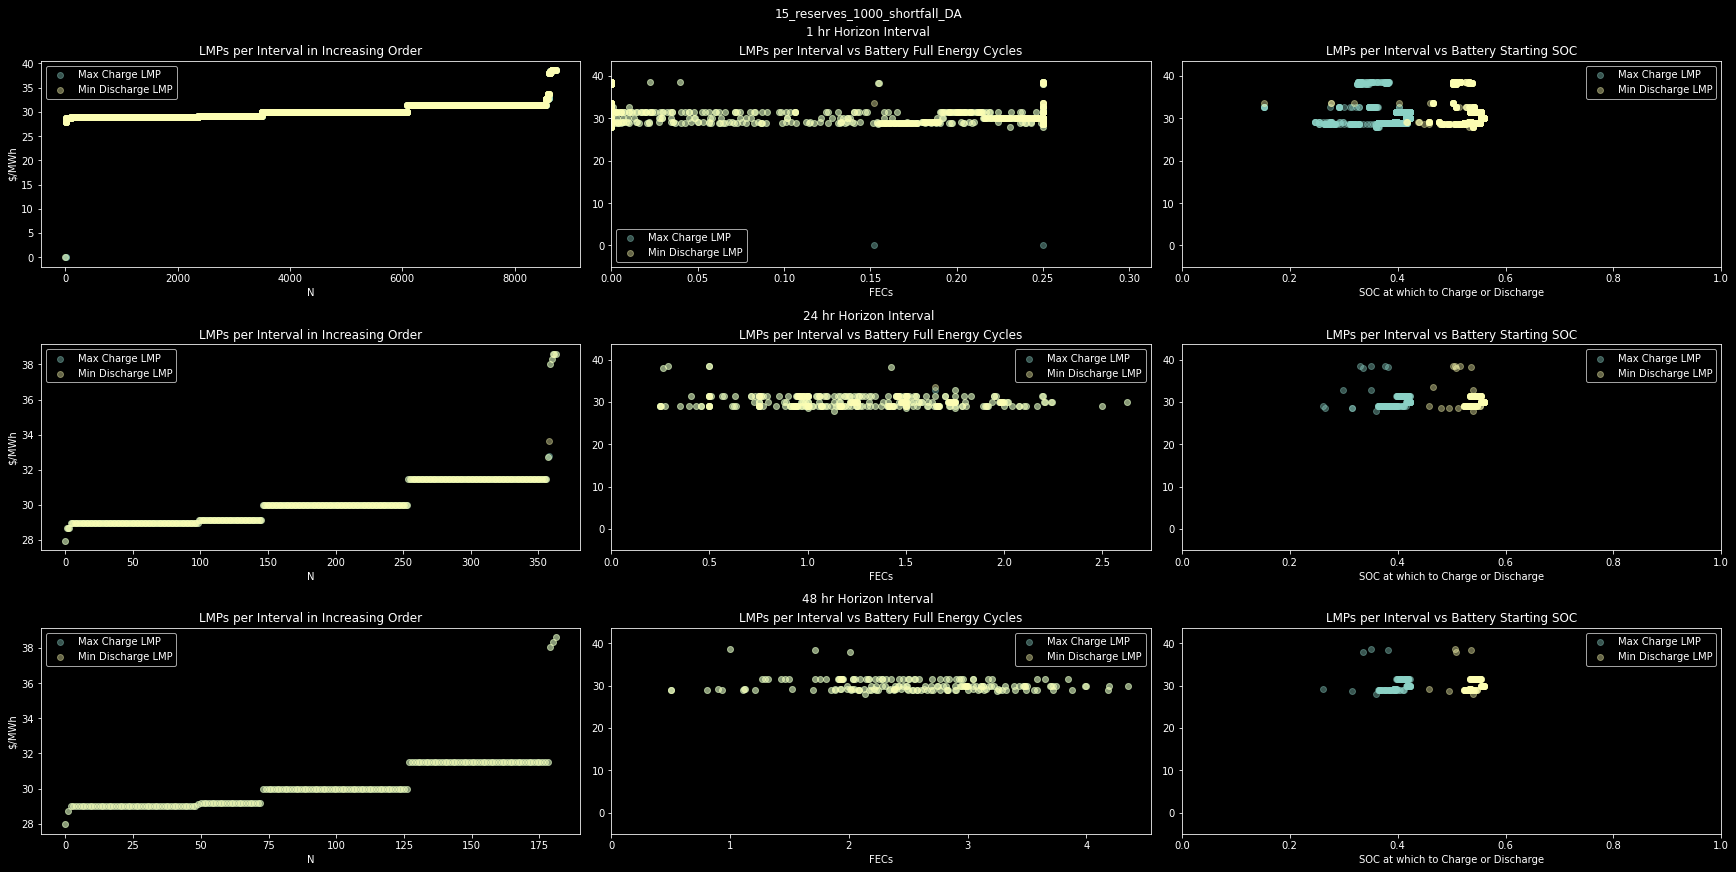

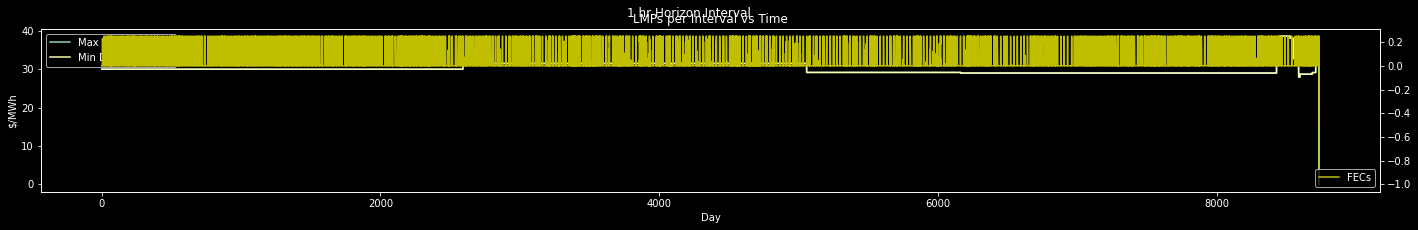

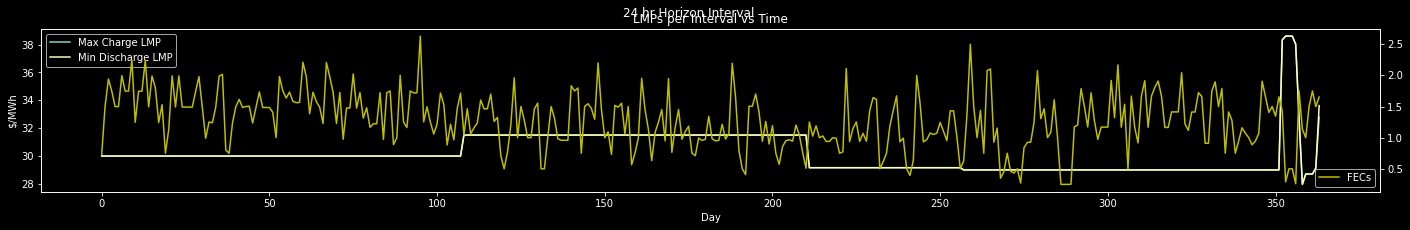

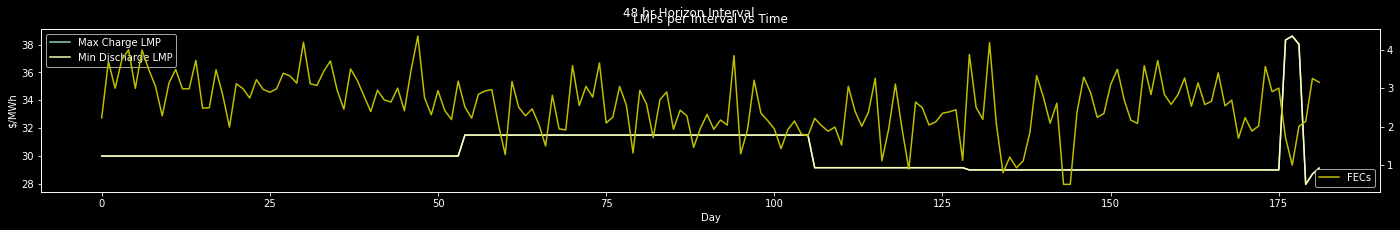

In [119]:
all_batt_plots(dfs[0], names[0])

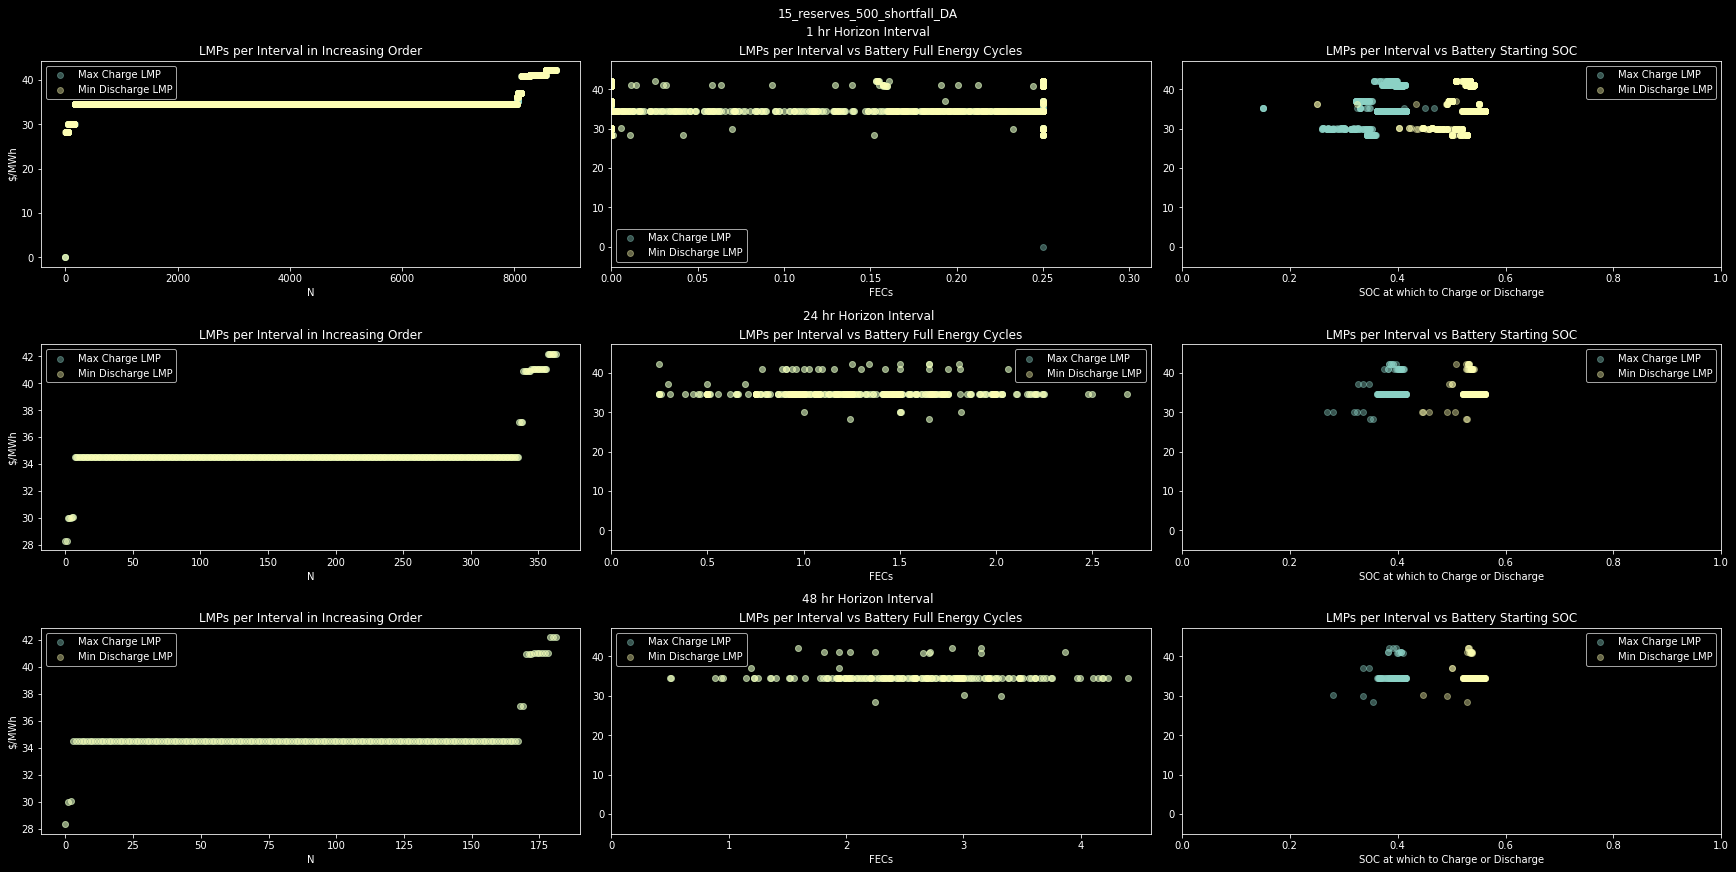

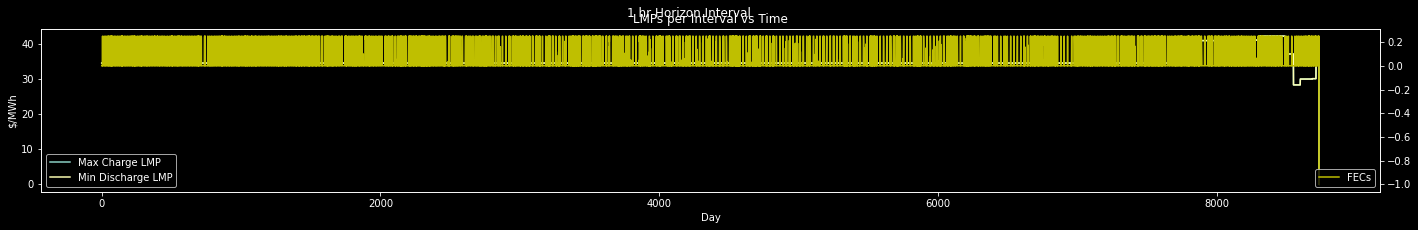

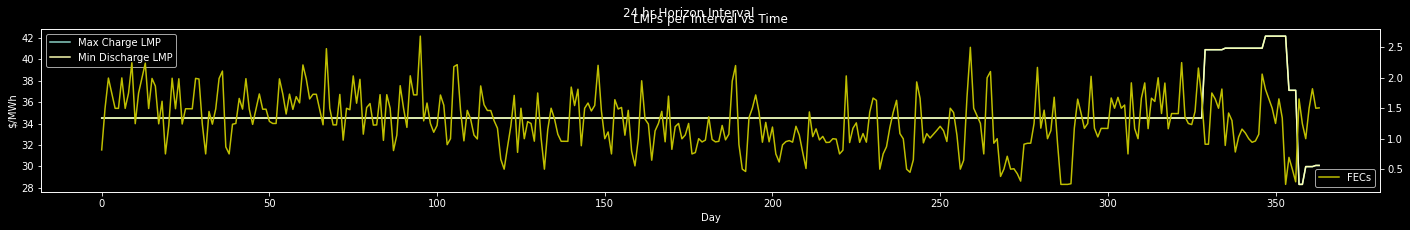

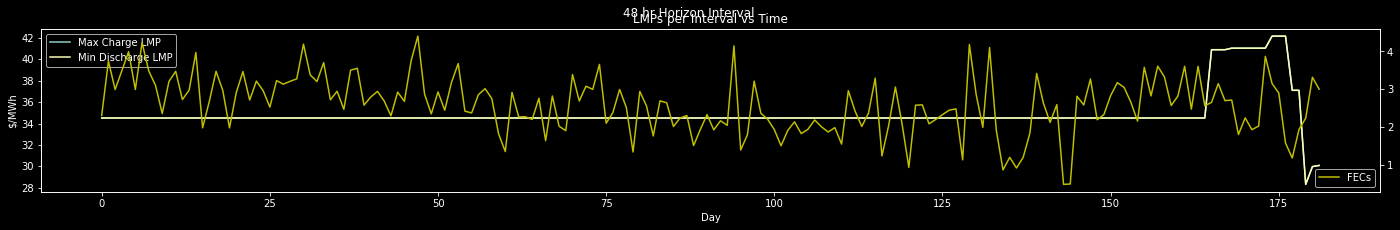

In [121]:
all_batt_plots(dfs[1], names[1])

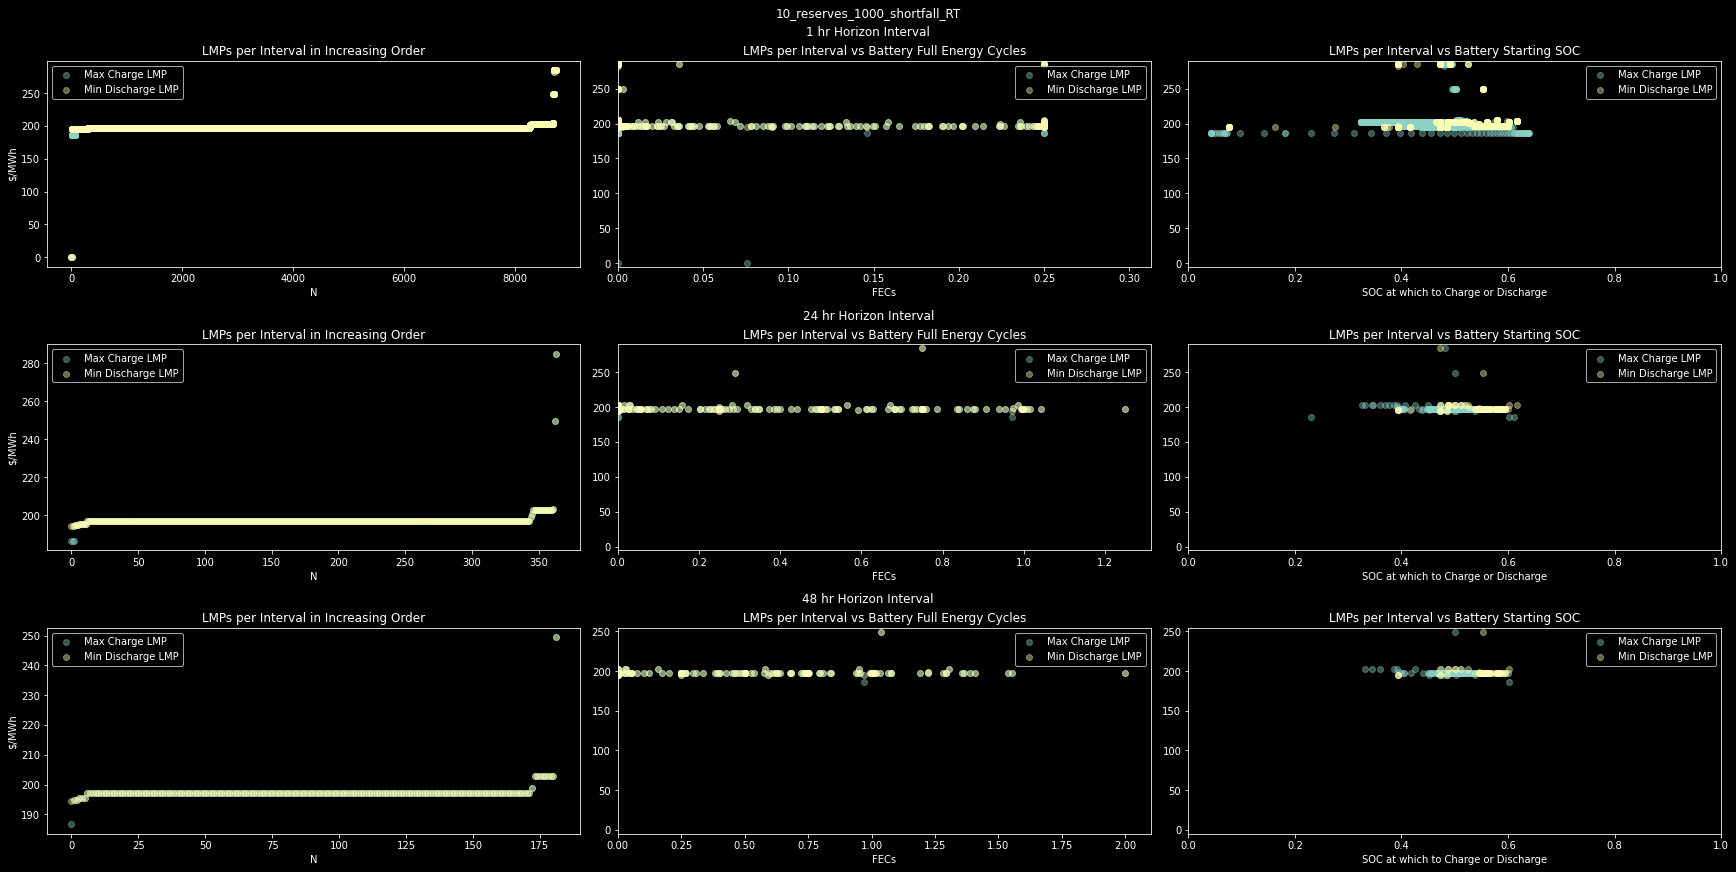

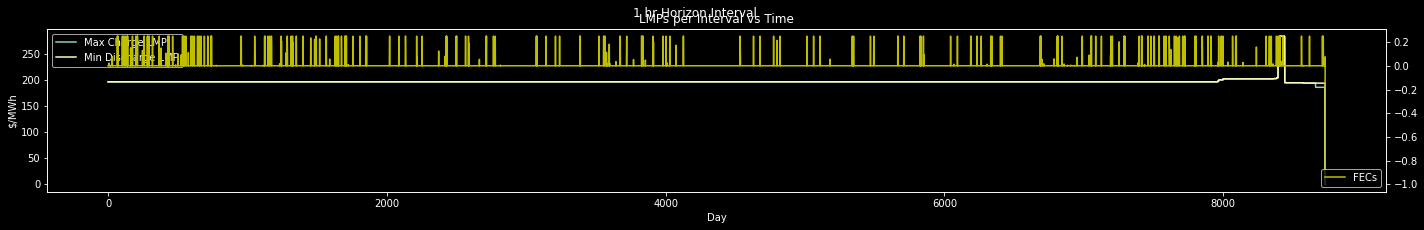

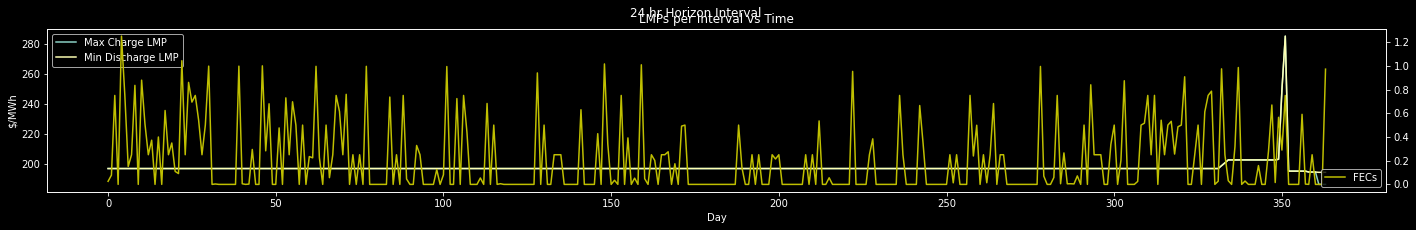

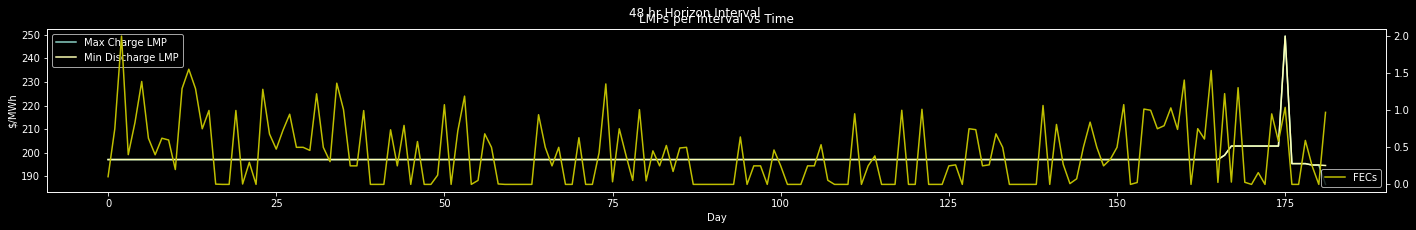

In [122]:
all_batt_plots(dfs[2], names[2])

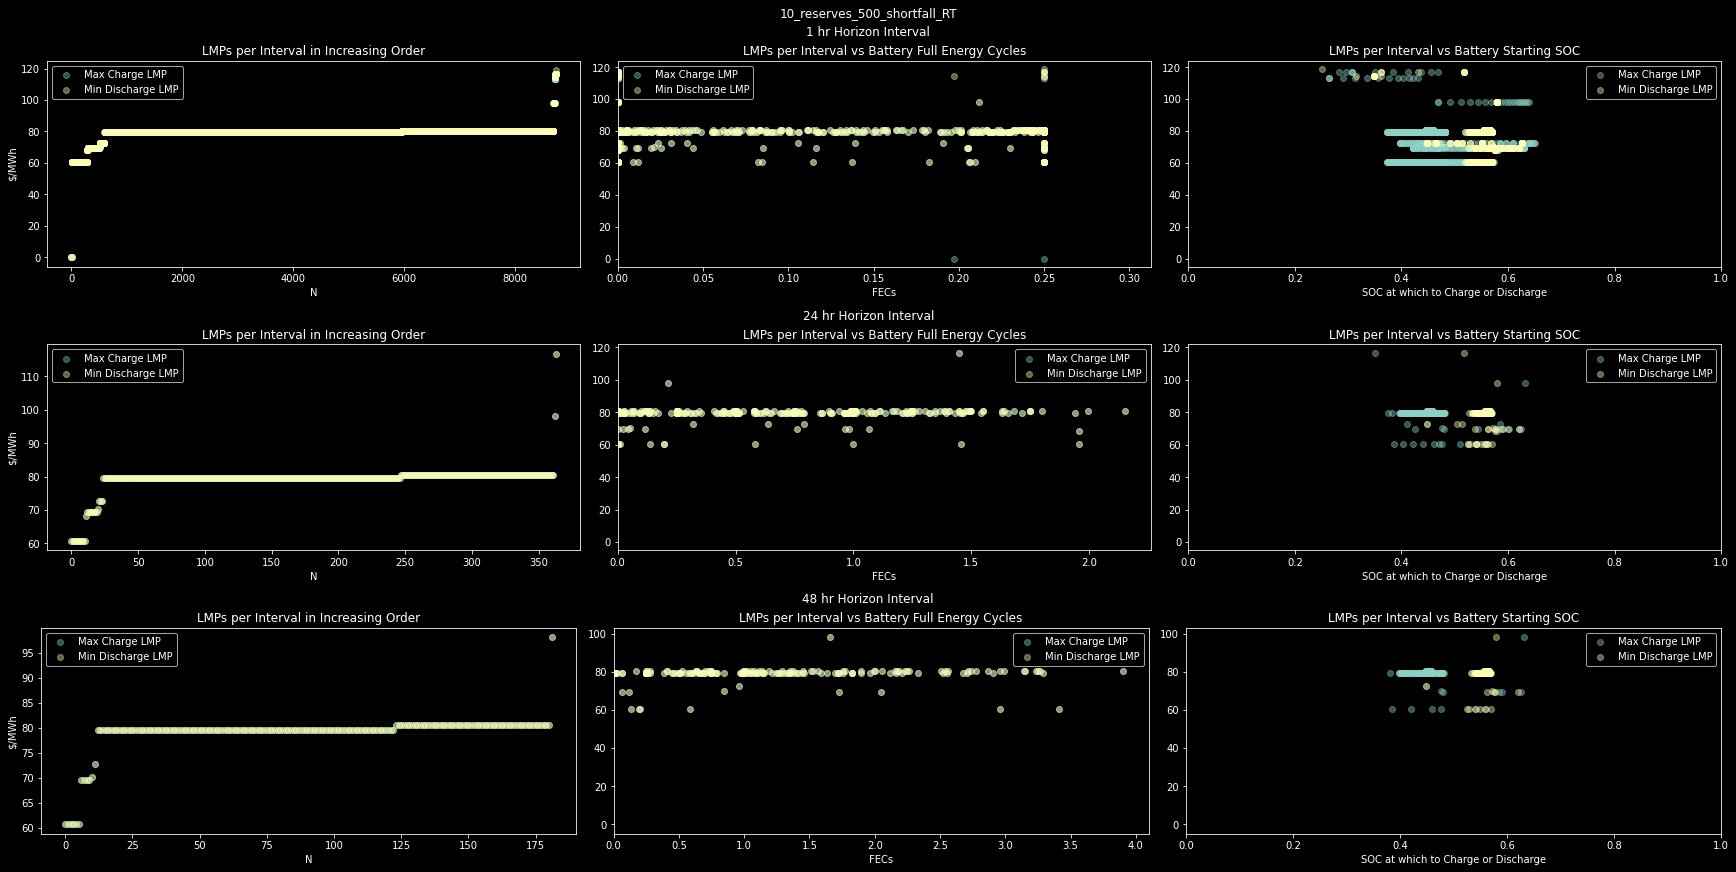

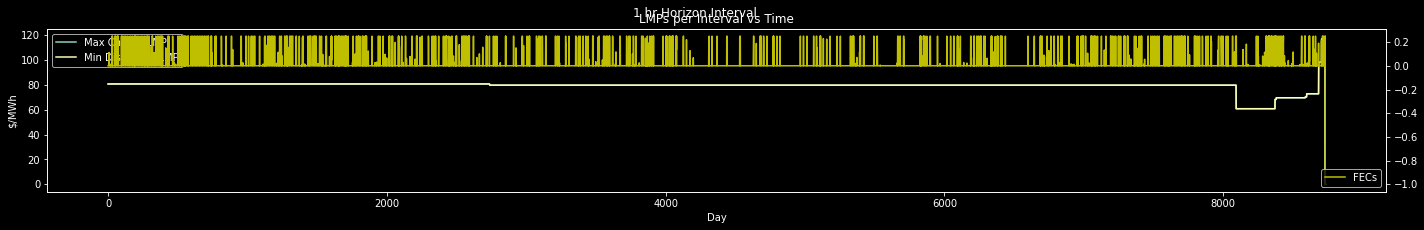

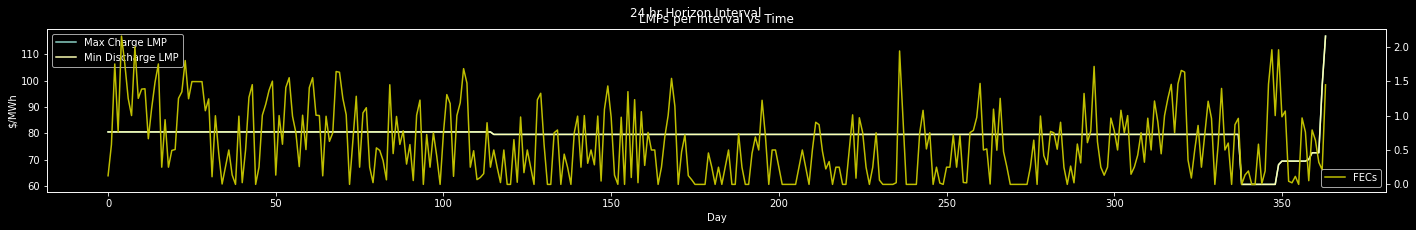

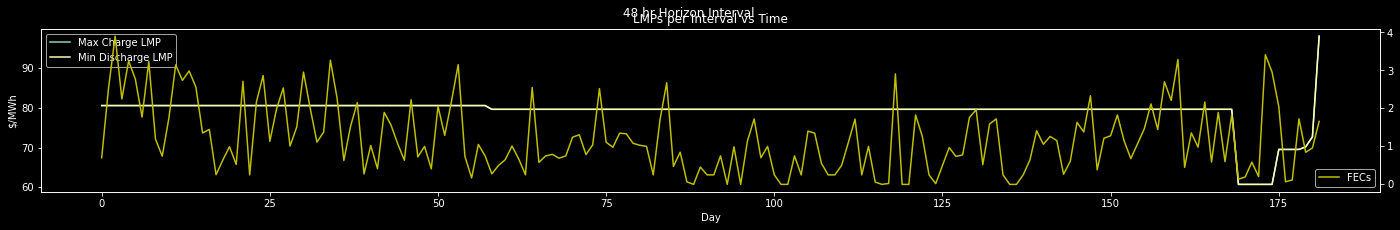

In [123]:
all_batt_plots(dfs[3], names[3])

Assuming the battery charges when LMP < Marginal Cost and Discharges when LMP > Marginal Cost
Break even Charge looks at Marginal Cost Bid where energy charged and discharged over the year is equivalent
Break even Cost looks at Marginal Cost Bid where the actual $/MWh earned is equal to the Required $/MWh to break even on capital investment


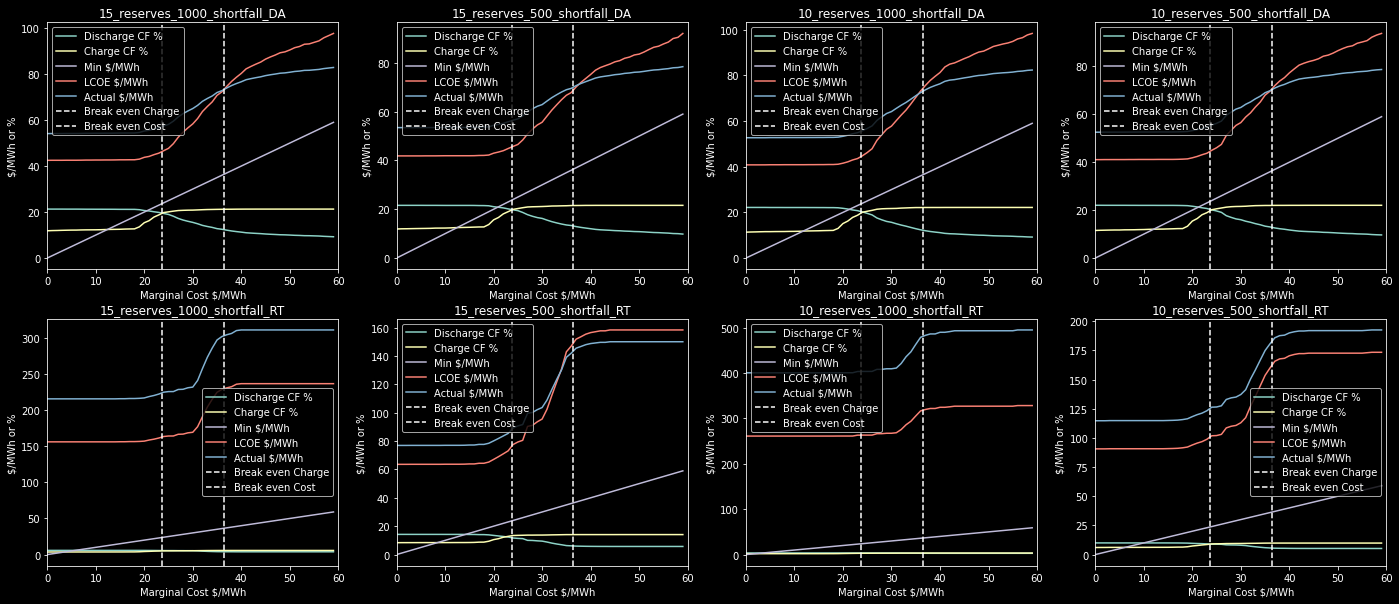

In [120]:
from dispatches.models.renewables_case.load_parameters import batt_cap_cost
# conservative bid curve based more on PPA: revenue at marginal cost >= x vs energy discharged at marginal cost >= x

print("Assuming the battery charges when LMP < Marginal Cost and Discharges when LMP > Marginal Cost")


discount_rate = 0.05
project_years = 30
def levelize(val, i=discount_rate, N=project_years):
    return val * N / (1 + i) ** N

def calc_ppa(rev, mwh, i=discount_rate, N=project_years):
    levelized_rev = levelize(rev, i, N)
    levelized_mwh = levelize(mwh, i, N)
    return levelized_rev / levelized_mwh

def calc_lcoe(mwh, costs, i=discount_rate, N=project_years):
    if type(costs) == float:
        costs = [costs] + [0] * N
    num = sum(costs[n] / (1+i)**n for n in range(N))
    den = sum(mwh[n] / (1+i)**n for n in range(1, N))
    return num/den


def lcoe_vs_marginal_cost(df, marginal_cost):
    """
    Calculates a few Financial numbers that depend on some combination of the marginal cost bid, how much energy is sold, 
    what the cleared LMP is, and the cost of the system

    `ppa_min` (Min $/MWh) is the simply the $/MWh of the energy bid. This is the minimum $/MWh received by the plant
    `ppa_act` (Act $/MWh) is the average, levelized $/MWh of energy sold at the LMPs, often above the marginal cost bid. 
        This is the actual $/MWh received by the plant (of course, holding dispatch steady)
    `lcoe` (LCOE $/MWh) is the cost of discharged battery energy and is the price of energy the system needs to receive 
        per unit dispatched, where the dispatch occurs whenever LMP >= marginal_cost
    `cap_factor` is the capacity factor of discharge
    `charge_cap_factor` is the CF of charging
    """
    batt_mw = df['batt_cap'].unique()[0]
    batt_cost = float(batt_mw * batt_cap_cost) * 1e3
    discharging = df.query(f'batt_to_grid_mw > 0.1 and lmp >= {marginal_cost}')
    discharging_lmps = discharging['lmp'].values
    discharging_mws = discharging['batt_to_grid_mw'].values
    ann_discharge = discharging_mws.sum()
    cap_factor = ann_discharge / batt_mw / 8760
    ann_discharge_rev_min = np.dot(ann_discharge, marginal_cost)
    ann_discharge_rev_act = np.dot(discharging_mws, discharging_lmps)
    # print(ann_discharge, ann_discharge / batt_mw, cap_factor)
    # print("Revenues min vs actual", ann_discharge_rev_min, ann_discharge_rev_act)

    charging = df.query(f'wind_to_batt_mw > 0.1 and lmp <= {marginal_cost}')
    charging_lmps = charging['lmp'].values
    charging_mws = charging['wind_to_batt_mw'].values
    ann_charge = charging_mws.sum()
    charge_cap_factor = ann_charge / batt_mw / 8760


    ppa_act = calc_ppa(ann_discharge_rev_act, ann_discharge)
    ppa_min = calc_ppa(ann_discharge_rev_min, ann_discharge)
    lcoe = calc_lcoe([ann_discharge] * project_years, batt_cost)
    return ppa_min, ppa_act, lcoe, cap_factor * 100, charge_cap_factor * 100

n = int(len(dfs) / 2)
fig, ax = plt.subplots(2, n, figsize=(24, 10))

runs = [
    '15_reserves_1000_shortfall',
    '15_reserves_500_shortfall',
    '10_reserves_1000_shortfall',
    '10_reserves_500_shortfall'
 ]
markets = ['DA', 'RT']

print("Break even Charge looks at Marginal Cost Bid where energy charged and discharged over the year is equivalent")
print("Break even Cost looks at Marginal Cost Bid where the actual $/MWh earned is equal to the Required $/MWh to break even on capital investment")
for n, r in enumerate(runs):
    for m, c in enumerate(markets):
        run_name = r + "_" + c
        df = dfs[names.index(run_name)]

        ppa_min = []
        ppa_act = []
        lcoe = []
        cf_percent = []
        charge_cf_percent = []
        for marginal_cost in range(0, 60):
            res = lcoe_vs_marginal_cost(df, marginal_cost)
            ppa_min.append(res[0])
            ppa_act.append(res[1])
            lcoe.append(res[2])
            cf_percent.append(res[3])
            charge_cf_percent.append(res[4])

        row = 0 if 'DA' in name else 1

        ax[m, n].plot(ppa_min, cf_percent, label="Discharge CF %")
        ax[m, n].plot(ppa_min, charge_cf_percent, label="Charge CF %")
        ax[m, n].plot(ppa_min, ppa_min, label="Min $/MWh")
        ax[m, n].plot(ppa_min, lcoe, label="LCOE $/MWh")
        ax[m, n].plot(ppa_min, ppa_act, label="Actual $/MWh")
        ax[m, n].set_xlim((0, 60))
        ax[m, n].axvline(x=23.7, linestyle='--', label="Break even Charge")
        ax[m, n].axvline(x=36.4, linestyle='--', label="Break even Cost")
        ax[m, n].legend()
        ax[m, n].set_xlabel("Marginal Cost $/MWh")
        ax[m, n].set_ylabel("$/MWh or %")
        # ax[m, n].set_aspect('equal', adjustable='box')
        ax[m, n].set_title(run_name)



In [ ]:
# Not sure how to parametrize RT bid: repeat DA bid or not?
# Since the LMPs are so much higher than DA, DA marginal cost bids is relatively low compared to RT LMPs for shortfall times
# Not sure how well this static parametrized bid curve can "guarantee" energy available for those shortfall times,
# especially since otherwise two market settlement will be highly punishing of missed DA promises
